# Borisov Dmitriy (6133-010402D)

Установка библиотеки pycuda

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627169 sha256=e0ffed84af7edc576004b5aba80063a766f889f6dc4bf6a43b43b04bb644332d
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=f3a71eec10d82e0c98dc926b19ac7878a9d4f82556e36e67b870352a9469b8f6
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


Импорт нужных библиотек и вывод информации о текущем GPU

In [4]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import pycuda.autoinit
from pycuda import driver, compiler, gpuarray, tools
tools.make_default_context().get_device().name()

'Tesla K80'

Информация о текущем CPU

In [5]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


Написание кода ядра

In [6]:
matmul_kernel = """
    __global__ void MatMulKernel(const float *a, const float *b, float *c, const int size)
    {
        int column = threadIdx.x + blockIdx.x * blockDim.x;
        int row = threadIdx.y + blockIdx.y * blockDim.y;
        
        float sum = 0;

        for (int i = 0; i < size; i++) {
            sum += a[row * size + i] * b[i * size + column];
        }

        c[row * size + column] = sum;
    }
"""

matmul = compiler.SourceModule(matmul_kernel).get_function("MatMulKernel")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Расчёт времени матричного умножения

In [12]:
mean_times_host_matmul = []     # Массив, содержащий средние времена вычислений на CPU
mean_times_dev_matmul = []      # Массив, содержащий средние времена вычислений на GPU
epsilon = 0.0001                # Необходим для сравнения матриц из дробный чисел
sizes = [128, 256, 512, 1024]    # Рассматриваемые размерности N матриц NxN
count_iteration = 15            # Количество итераций без "холодного старта"

for size in sizes:

  # Создание данных и выделение памяти на CPU
  host_a = np.random.randn(size, size).astype(np.float32)
  host_b = np.random.randn(size, size).astype(np.float32)
  host_c = np.zeros((size, size), dtype=np.float32)
  numpy_c = np.zeros((size, size), dtype=np.float32)

  # Выделение памяти на GPU
  dev_a = driver.mem_alloc(host_a.nbytes)
  dev_b = driver.mem_alloc(host_b.nbytes)
  dev_c = driver.mem_alloc(host_c.nbytes)

  """
  Вычисление размерности блоков и сетки блоков.
  Каждый блок состоит из варпов (32 нити) и содержит макс. 1024 нити
  """
  if size > 32:
    gdim, remains = divmod(size, 32)  # divmod(a, b) return a // b, a % b

    # Двумерный блок из 32 варпов
    bdim = (32, 32, 1)
    # Вычисление размерности сетки блоков                
    gdim = (gdim + (remains > 0), gdim + (remains > 0))
  else:
    bdim = (size, size, 1)
    gdim = (1, 1)

  # Массивы с временами на соответствующем устройстве для вычисления среднего 
  times_host_matmul = []
  times_dev_matmul = []

  for i in range(count_iteration + 1):
    # Вычисление времени на GPU (с учётом пересылки данных)
    start_time = time()
    driver.memcpy_htod(dev_a, host_a) 
    driver.memcpy_htod(dev_b, host_b)
    matmul(dev_a, dev_b, dev_c, np.int32(size), block=bdim, grid=gdim)
    driver.memcpy_dtoh(host_c, dev_c)
    end_time = time()
    times_dev_matmul.append(end_time - start_time)

    # Вычисление времени на CPU
    start_time = time()
    numpy_c = np.dot(host_a, host_b)
    end_time = time()
    times_host_matmul.append(end_time - start_time)

  # Вычтсление среднего значения времени без "холодного старта"
  mean_times_dev_matmul.append(np.mean(times_dev_matmul[1:]))
  mean_times_host_matmul.append(np.mean(times_host_matmul[1:]))

  # Сравнение матриц на CPU и на GPU с допустимой погрешностью в epsilon
  print(f"Size = {size}. numpy_c равен host_c с погрешностью {epsilon}?\t" + 
        str(np.allclose(numpy_c, host_c, atol=epsilon)))

print(f"CPU = {mean_times_host_matmul}")
print(f"GPU = {mean_times_dev_matmul}")

Size = 128. numpy_c равен host_c с погрешностью 0.0001?	True
Size = 256. numpy_c равен host_c с погрешностью 0.0001?	True
Size = 512. numpy_c равен host_c с погрешностью 0.0001?	True
Size = 1024. numpy_c равен host_c с погрешностью 0.0001?	True
CPU = [0.0001613775889078776, 0.0006404399871826171, 0.004334767659505208, 0.03319102923075358]
GPU = [0.00024601618448893227, 0.0007328192392985026, 0.0039055665334065755, 0.026323715845743816]


Сравнение скоростей двух реализаций

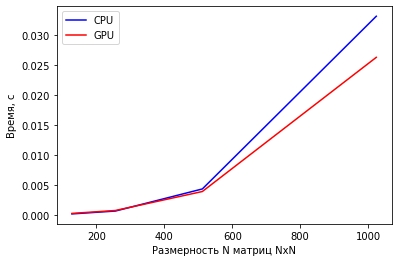

In [13]:
plt.plot(sizes, mean_times_host_matmul, color="blue", label="CPU")
plt.plot(sizes, mean_times_dev_matmul, color="red", label="GPU")
plt.xlabel("Размерность N матриц NxN")
plt.ylabel("Время, с")
plt.legend()

Визуализация ускорения на GPU

Text(0, 0.5, 'Отношение времени на CPU к времени на GPU')

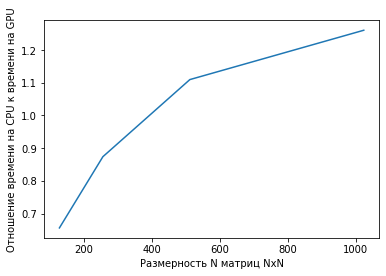

In [14]:
plt.plot(sizes, np.array(mean_times_host_matmul) / np.array(mean_times_dev_matmul))
plt.xlabel("Размерность N матриц NxN")
plt.ylabel("Отношение времени на CPU к времени на GPU")

Сохранение результатов в excel

In [15]:
df = pd.DataFrame({"CPU": mean_times_host_matmul, "GPU": mean_times_dev_matmul}, index=sizes)
df.to_excel("CPU and GPU.xlsx")
df

,CPU,GPU
128,0.000161,0.000246
256,0.000640,0.000733
512,0.004335,0.003906
1024,0.033191,0.026324
